In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import struct
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define class names for reference
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def load_idx_file(file_path):
    """
    Load IDX file format (used by Fashion MNIST)
    """
    with open(file_path, 'rb') as f:
        # Read the header
        magic = struct.unpack('>I', f.read(4))[0]
        num_images = struct.unpack('>I', f.read(4))[0]
        
        if magic == 2051:  # Image file
            num_rows = struct.unpack('>I', f.read(4))[0]
            num_cols = struct.unpack('>I', f.read(4))[0]
            
            # Read the image data
            buf = f.read(num_images * num_rows * num_cols)
            data = np.frombuffer(buf, dtype=np.uint8)
            data = data.reshape(num_images, num_rows, num_cols)
            
            return data
        elif magic == 2049:  # Label file
            # Read the label data
            buf = f.read(num_images)
            labels = np.frombuffer(buf, dtype=np.uint8)
            
            return labels
        else:
            raise ValueError(f"Unknown magic number: {magic}")



In [3]:
# Path configuration - updated for your exact paths
base_dir = r"C:\Users\bkc_k\Downloads\fashionmnist"
train_image_path = os.path.join(base_dir, "data", "train_images", "train-images-idx3-ubyte")
test_image_path = os.path.join(base_dir, "data", "test_images", "test-images-idx3-ubyte")
train_csv_path = os.path.join(base_dir, "train.csv")
test_csv_path = os.path.join(base_dir, "test.csv")

In [4]:
# Verify file existence
for path in [train_image_path, test_image_path, train_csv_path, test_csv_path]:
    if not os.path.exists(path):
        print(f"Warning: File not found: {path}")
        if path == train_image_path:
            # Try alternative train image paths
            alternative_paths = [
                os.path.join(base_dir, "data", "train", "train-images-idx3-ubytes"),
                os.path.join(base_dir, "data", "train_images", "train-images.idx3-ubyte"),
                os.path.join(base_dir, "data", "train_images", "train-images-idx3-ubyte")
            ]
            for alt_path in alternative_paths:
                if os.path.exists(alt_path):
                    train_image_path = alt_path
                    print(f"Found alternative train image path: {alt_path}")
                    break
        elif path == test_image_path:
            # Try alternative test image paths
            alternative_paths = [
                os.path.join(base_dir, "data", "test", "test-images-idx3-ubytes"),
                os.path.join(base_dir, "data", "test_images", "test-images.idx3-ubyte"),
                os.path.join(base_dir, "data", "test_images", "test-images-idx3-ubyte")
            ]
            for alt_path in alternative_paths:
                if os.path.exists(alt_path):
                    test_image_path = alt_path
                    print(f"Found alternative test image path: {alt_path}")
                    break

In [5]:
# Load images
print("Loading images...")
try:
    train_images = load_idx_file(train_image_path)
    test_images = load_idx_file(test_image_path)
except Exception as e:
    print(f"Error loading image data: {str(e)}")
    raise

Loading images...


In [6]:
# Load labels from CSV
print("Loading labels from CSV...")
try:
    train_df = pd.read_csv(train_csv_path)
    test_df = pd.read_csv(test_csv_path)
except Exception as e:
    print(f"Error loading CSV data: {str(e)}")
    raise

Loading labels from CSV...


In [7]:
# Check if loaded correctly
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_df.shape}")
print(f"Test labels shape: {test_df.shape}")


Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)
Train labels shape: (60000, 2)
Test labels shape: (10000, 1)


In [8]:
# Display first few rows of the dataframes to understand structure
print("\nTrain DataFrame sample:")
print(train_df.head())
print("\nTest DataFrame sample:")
print(test_df.head())


Train DataFrame sample:
   id  label
0   1      9
1   2      0
2   3      0
3   4      3
4   5      0

Test DataFrame sample:
      id
0  60001
1  60002
2  60003
3  60004
4  60005


In [9]:
# Extract labels from the training dataframe
# column 1 contains labels (index 1) if there are 2 columns
if train_df.shape[1] == 2:
    # Get column names
    columns = train_df.columns.tolist()
    print(f"Train columns: {columns}")
    
    # Assume first column is ID, second is label
    id_col = columns[0]
    label_col = columns[1]
    
    train_labels = train_df[label_col].values
    print(f"Using '{label_col}' as the label column")
else:
    # If we can't determine the label column, try common names
    label_candidates = ['label', 'class', 'target', 'category']
    label_col = None
    
    for candidate in label_candidates:
        if candidate in train_df.columns:
            label_col = candidate
            break
    
    if label_col:
        train_labels = train_df[label_col].values
        print(f"Using '{label_col}' as the label column")
    else:
        raise ValueError("Cannot determine which column contains the labels in the training data")

Train columns: ['id', 'label']
Using 'label' as the label column


In [10]:
# Check for correct number of samples
if train_images.shape[0] != len(train_df):
    print(f"Warning: Number of training images ({train_images.shape[0]}) doesn't match number of rows in train CSV ({len(train_df)})")
if test_images.shape[0] != len(test_df):
    print(f"Warning: Number of test images ({test_images.shape[0]}) doesn't match number of rows in test CSV ({len(test_df)})")

In [11]:
# Preprocess images
# Normalize pixel values to range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Reshape images to add channel dimension for Keras
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

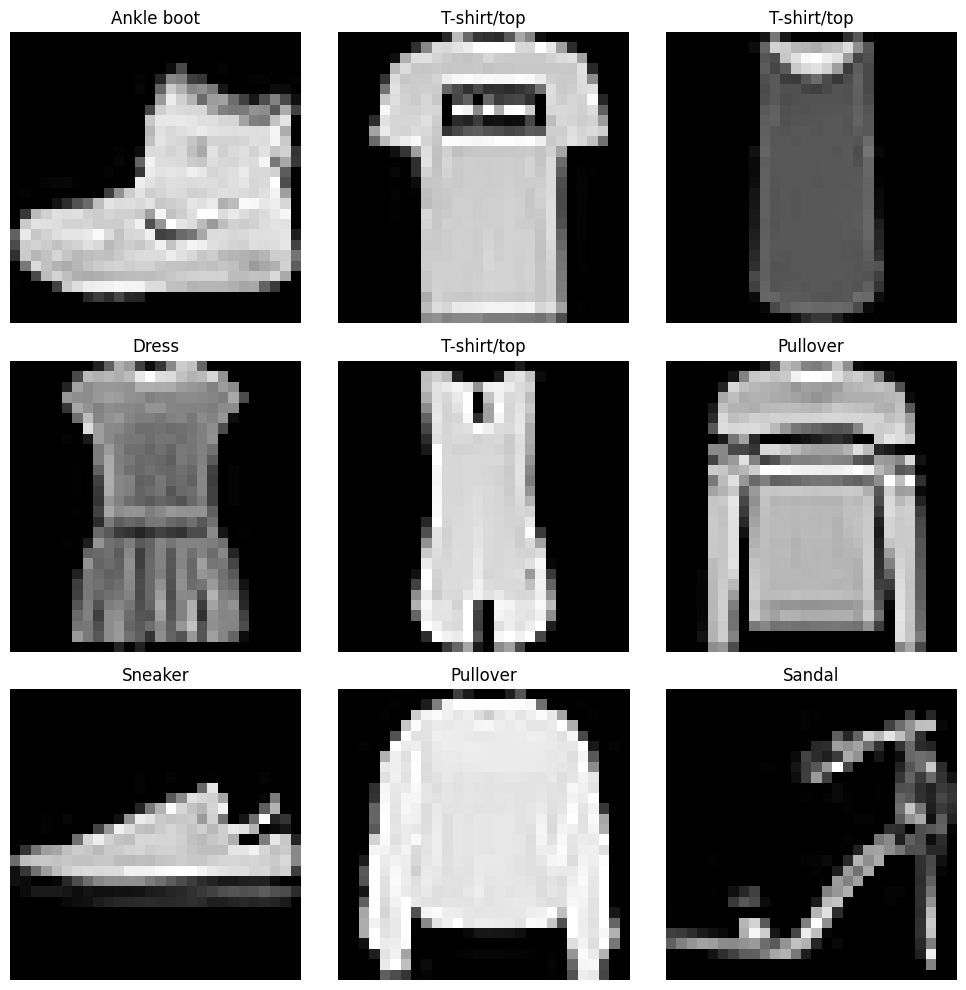

In [12]:
# Display sample images to verify data
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.title(class_names[train_labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'sample_fashion_mnist.png'))
plt.show()
plt.close()

In [13]:
# Split training data into train and validation
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

In [14]:
# Data augmentation for better model generalization
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(train_images)

In [15]:
# Create CNN model
def create_model():
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third convolutional block (deeper network)
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')  # 10 classes for Fashion MNIST
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
print("Creating model...")
model = create_model()
model.summary()

# Callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Train model
print("Training model...")
batch_size = 64
epochs = 100

history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    validation_data=(val_images, val_labels),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Creating model...


C:\Users\bkc_k\Downloads\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 885,738 (3.38 MB)

 Trainable params: 883,818 (3.37 MB)

 Non-trainable params: 1,920 (7.50 KB)

Training model...


C:\Users\bkc_k\Downloads\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 674s 830ms/step - accuracy: 0.6630 - loss: 1.0153 - val_accuracy: 0.8287 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 554s 738ms/step - accuracy: 0.8163 - loss: 0.4970 - val_accuracy: 0.8712 - val_loss: 0.3406 - learning_rate: 0.0010
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 583s 777ms/step - accuracy: 0.8427 - loss: 0.4279 - val_accuracy: 0.8846 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1491s 2s/step - accuracy: 0.8566 - loss: 0.3872 - val_accuracy: 0.8893 - val_loss: 0.2913 - learning_rate: 0.0010
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 586s 780ms/step - accuracy: 0.8695 - loss: 0.3597 - val_accuracy: 0.8983 - val_loss: 0.2712 - learning_rate: 0.0010
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 560s 746ms/step - accuracy: 0.8702 - loss: 0.3467 - val_accuracy: 0.9031 - val_loss: 0.2611 - learning_rate: 0.0010
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 554s 736ms/step - a

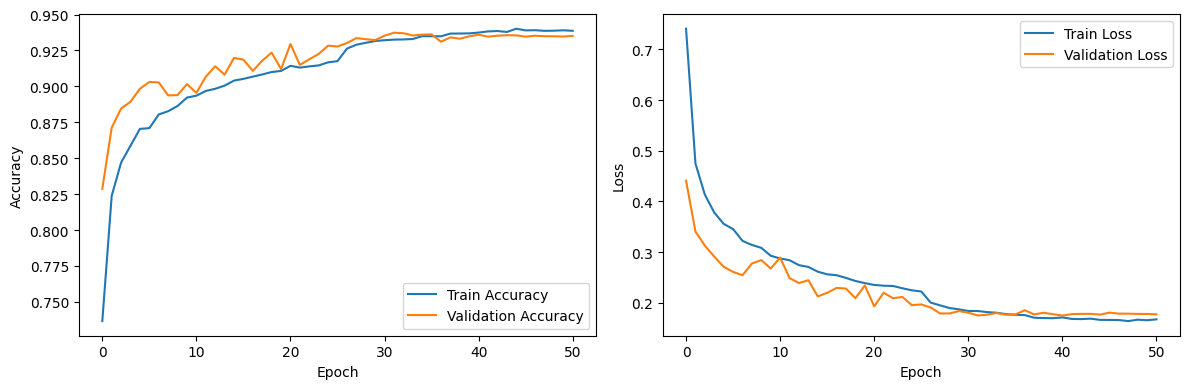

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'training_history.png'))
plt.show()
plt.close()

In [17]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc:.4f}")

375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9363 - loss: 0.1687
Validation accuracy: 0.9359


In [18]:
# Make predictions on test set
test_predictions = model.predict(test_images)
test_pred_classes = np.argmax(test_predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step


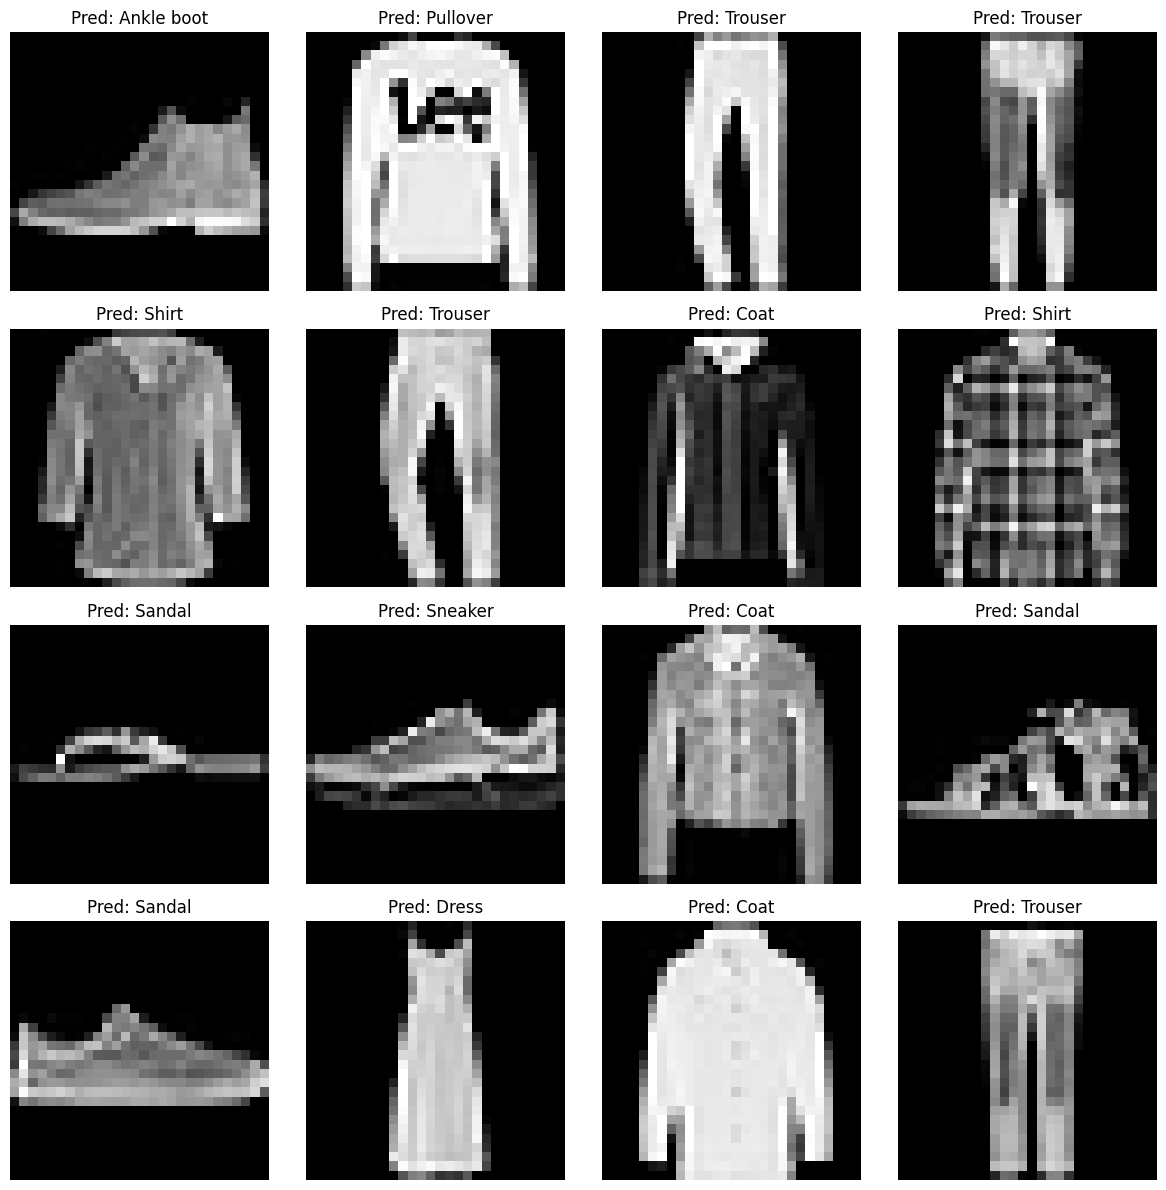

In [36]:
# Visualize some predictions
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    predicted_label = test_pred_classes[i]
    plt.title(f"Pred: {class_names[predicted_label]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'prediction_examples.png'))
plt.show()
plt.close()

In [19]:
# Save model
model_path = os.path.join(base_dir, 'fashion_mnist_model.h5')
model.save(model_path)
print(f"Model saved as '{model_path}'")

Model saved as 'C:\Users\bkc_k\Downloads\fashionmnist\fashion_mnist_model.h5'


In [20]:
# Get the ID column from test DataFrame
if test_df.shape[1] == 1:
    # If there's only one column, use it as the ID
    id_col = test_df.columns[0]
else:
    # Try to find an ID column if there are multiple columns
    id_candidates = ['id', 'image_id', 'idx']
    id_col = None
    
    for candidate in id_candidates:
        if candidate in test_df.columns:
            id_col = candidate
            break
    
    if id_col is None:
        id_col = test_df.columns[0]  # Default to the first column

In [21]:
# Create submission file
print(f"Using '{id_col}' as the ID column for submission")
submission_df = pd.DataFrame({
    id_col: test_df[id_col],
    'label': test_pred_classes
})
submission_path = os.path.join(base_dir, 'submission_1.csv')
submission_df.to_csv(submission_path, index=False)
print(f"Predictions saved to '{submission_path}'")

Using 'id' as the ID column for submission
Predictions saved to 'C:\Users\bkc_k\Downloads\fashionmnist\submission_1.csv'


In [22]:
# Output final model performance
print("\nTraining completed successfully!")
print(f"Final validation accuracy: {val_acc:.4f}")
print(f"Model saved to: {model_path}")
print(f"Predictions saved to: {submission_path}")


Training completed successfully!
Final validation accuracy: 0.9359
Model saved to: C:\Users\bkc_k\Downloads\fashionmnist\fashion_mnist_model.h5
Predictions saved to: C:\Users\bkc_k\Downloads\fashionmnist\submission_1.csv
